### Define Function

In [1]:
# %config InlineBackend.figure_format = 'svg'
import seaborn as sns
import numpy as np
import pandas as pd

from system_dynamics import *
from plot_utilities import *


color_list = sns.color_palette()

yaml_file = open("parameters.yml")
parsed_yaml_file = yaml.load(yaml_file, Loader=yaml.FullLoader)["parameters"]
T = parsed_yaml_file['T']
n = parsed_yaml_file['n']
m = parsed_yaml_file['m']
p = parsed_yaml_file['p']

def TaskLoss(Shat, S, Phi):
    loss = (Shat - S) @ Phi @ (Shat - S).T
    loss = np.trace(loss)/Shat.shape[0]
    return loss

### delta = l-2 norm bound
def AdvLoss(S, delta = 0.01, sample_n=1, show_plot=False): # random_seed=326,

    ### same time series
    # S, MU_train, ALPHA_train, BETA_train, SIGMA_train = ARIMA_gen(random_seed=0, sample_n=sample_n)

    # Phi, orig_cost = CtrlTask(random_seed, T=S.shape[1])
    Phi, orig_cost = CtrlTaskIndentity(s=S, T=S.shape[1])

    val, vec = np.linalg.eigh(Phi)
    assert val[0] >= 0, "Phi not Positive Semi Definite"

    # optimal attack
    adv_noise = delta * vec[:, -1]
    S_loss_adv = S + adv_noise
    adv_loss = TaskLoss(S_loss_adv, S, Phi)

    # baseline (uniform noise)
    random_noise = np.random.randint(low=-20, high=20, size=(S.shape[0], S.shape[1]))
    random_noise = delta * random_noise / np.linalg.norm(random_noise, ord=2)
    S_random = S + random_noise
    random_loss = TaskLoss(S_random, S, Phi)

    if show_plot:
        figure ,ax = LineChart([np.arange(S.shape[1])]*3, [S[0], S_loss_adv[0], S_random[0]], color=color_list, title="Time Series $S$ with $\delta={}$".format(delta), legend_loc="lower right", line_style=['-', '--', '-.'], 
            legend=["Original", "Cost Adv", "Random"], ylim=(0.5, 2.5), save_path="./plots/ARIMA time series delta{}.pdf".format(delta))

    return (orig_cost, adv_loss+orig_cost, random_loss+orig_cost), (S[0], S_loss_adv[0], S_random[0])


In [148]:
import cvxpy as cp
import pandas as pd

### Constrainted Input-Driven MPC

class ConstraintedController():
    def __init__(self, S, A, B, C, Q, R, x0, umax, umin):
        self.A = A
        self.B = B
        self.C = C
        self.Q = Q
        self.R = R
        self.x0 = x0
        self.umax = umax
        self.umin = umin
        
        self.x_var = cp.Variable((n, S.shape[1]+1))
        self.u_var = cp.Variable((m, S.shape[1]))
        self.S_par = cp.Parameter((p, S.shape[1]))

        self.constr = []
        # self.constr.append( self.u_var <= umax*np.ones_like(self.u_var) )
        # self.constr.append( self.umin*np.ones_like(self.u_var) <= self.u_var )
        self.constr.append( self.u_var <= self.umax )
        self.constr.append( self.umin <= self.u_var )

        ### initialize
        self.constr.append( self.x_var[:, 0] == x0 )
        obj = cp.quad_form(self.x_var[:, -1], Q)
        
        for tt in range(1, S.shape[1]+1):
            self.constr.append( self.x_var[:, tt] == A@self.x_var[:, tt-1] + B@self.u_var[:, tt-1] + C@self.S_par[:, tt-1] )
        
        for tt in range(0, S.shape[1]):
            obj += cp.quad_form(self.x_var[:, tt], Q)
            obj += cp.quad_form(self.u_var[:, tt], R)

        self.prob = cp.Problem(cp.Minimize(obj), self.constr)

        # return self.prob.value, self.u_var.value
    
    def Solve(self, S_value):
        self.S_par.value = S_value
        self.prob.solve(solver=cp.CPLEX, verbose=False)#, eps=1e-4)
        assert self.prob.status != "infeasible", "Problem infeasible, why?"
        return

    def Backward(self, x_grad, u_grad):
        self.prob.solve(requires_grad=True, solver=cp.SCS, verbose=False)#, eps=1e-4)
        self.x_var.gradient = x_grad
        self.u_var.gradient = u_grad
        self.prob.backward()
        return self.S_par.gradient   

    ### calculate cost
    def CalCost(self, S_real, u_observe):
        x0 = np.array(self.x0).reshape(n, 1)
        cost = x0.T @ self.Q @ x0
        x = np.zeros((S_real.shape[0], S_real.shape[1]+1))
        x[:, 0] = self.x0

        for tt in range(1, S_real.shape[1]+1):
            # print(type(x), type(u_observe), type(S_real))
            x[:, tt] = self.A @ x[:, tt-1] + self.B @ u_observe[:, tt-1] + self.C @ S_real[:, tt-1]
            cost += x[:, tt].T @ self.Q @ x[:, tt]
            cost += u_observe[:, tt-1].T @ self.R @ u_observe[:, tt-1]
        return float(cost)


def AdvConstr(S, umax, umin, delta = 0.01, sample_n=1, show_plot=False): # , random_seed

    # S, MU_train, ALPHA_train, BETA_train, SIGMA_train = ARIMA_gen(random_seed=0, sample_n=1)

    x0 = 1
    A = np.eye(1, dtype=np.float64)
    B = - np.eye(1, dtype=np.float64)
    C = np.eye(1, dtype=np.float64)
    Q = np.eye(1, dtype=np.float64)
    R = np.eye(1, dtype=np.float64)

    controller = ConstraintedController(S, A, B, C, Q, R, x0, umax, umin)
    controller.Solve(S)
    cost_orig, u_orig = controller.prob.value, controller.u_var.value 
    # print(u_orig.shape)

    ### Random noise
    rand_vec = np.random.randint(low=-20, high=20, size=(S.shape[0], S.shape[1]))
    rand_vec = delta * rand_vec / np.linalg.norm(rand_vec, ord=2)
    S_rand = S + rand_vec
    controller.Solve(S_rand)
    _, u_rand = controller.prob.value, controller.u_var.value
    # print(u_rand)
    cost_rand = controller.CalCost(S, u_rand)

    ### constraint umax
    max_one_hot = np.zeros(controller.u_var.shape)
    max_one_hot[0, np.argmax(controller.u_var.value)] = 1.
    # print(np.argmax(controller.u_var.value), controller.u_var.value[:, 9], controller.u_var.value[:, 105])
    S_grad = controller.Backward(x_grad=np.zeros(controller.x_var.shape), u_grad=max_one_hot)
    # print(S_grad.shape, S_grad, controller.u_var.value)

    S_constr1_adv = S + delta/np.linalg.norm(S_grad, ord=2) * S_grad
    controller.Solve(S_constr1_adv)
    _, u_new1 = controller.prob.value, controller.u_var.value
    cost_new1 = controller.CalCost(S, u_new1)

    ### constraint \|u\|_1
    u_grad = np.zeros(controller.u_var.shape)
    for tt1 in range(u_grad.shape[0]):
        for tt2 in range(u_grad.shape[1]):
            u_grad[tt1, tt2] = 1 if controller.u_var.value[tt1, tt2] >= 0 else -1

    S_grad = controller.Backward(x_grad=np.zeros(controller.x_var.shape), u_grad=u_grad)

    S_constr2_adv = S + delta/np.linalg.norm(S_grad, ord=2) * S_grad
    controller.Solve(S_constr2_adv)
    _, u_new2 = controller.prob.value, controller.u_var.value
    # print(np.isnan(u_new2).any())
    cost_new2 = controller.CalCost(S, u_new2)

    if show_plot:
        LineChart([np.arange(S.shape[1])]*3, [S[0], S_constr1_adv[0], S_constr2_adv[0]], color=color_list, title="Time Series $S$ with $\delta={}$".format(delta), legend_loc="lower left", line_style=['-', '--', '-.'], 
            legend=["Original", "max($u_t$) Adv", "sum($u_t$) Adv"], ylim=(-0.5, 2.5), save_path="./plots/constr time series delta{}.pdf".format(delta))
        LineChart([np.arange(S.shape[1]-1)]*5, [u_orig[0], u_new1[0], u_new2[0], [umax]*(S.shape[1]-1), [umin]*(S.shape[1]-1)], title="Control $u$ with $\delta={}$".format(delta), legend_loc="lower left", line_style=['-', '--', '-.', ':', ':'], 
            legend=["Original", "max($u_t$) Adv", "sum($u_t$) Adv", "$u_{max}$", "$u_{min}$"], save_path="./plots/control series delta{}.pdf".format(delta))

    return (cost_orig, cost_new1, cost_new2, cost_rand), (S[0], S_constr1_adv[0], S_constr2_adv[0], S_rand[0]), (u_orig[0], u_new1[0], u_new2[0], u_rand[0])


### ARIMA cost adversarial

In [83]:
delta_list = [0.3, 1, 3]

df = pd.DataFrame({'$L_2$ norm bound $\delta$' : [], 'Scenario': [], 'Cost': []})
ts_np = np.ndarray((len(delta_list), 3, T)) ### delta x scebnario x T

# fig, ts_ax_list = plt.subplots(3, 2, sharex=True, figsize=(5, 3))
fig_index = 0

for delta in delta_list:
    for run in range(10):
        ### same time series
        S, MU_train, ALPHA_train, BETA_train, SIGMA_train = ARIMA_gen(random_seed=run+1, sample_n=1)
        # print(S[:, 0:5])
        cost, data = AdvLoss(S, delta=delta, show_plot=False)
        if (run == 0):
            ts_np[fig_index, 0, :] = data[0]
            ts_np[fig_index, 1, :] = data[1]
            ts_np[fig_index, 2, :] = data[2]

            fig_index += 1

        df.loc[len(df.index)] = [str(delta), 'Original', cost[0]] 
        df.loc[len(df.index)] = [str(delta), 'Cost Adv', cost[1]]
        df.loc[len(df.index)] = [str(delta), 'Random', cost[2]]

np.save("./plots/ARIMA adv cost ts.npy", ts_np)

df.to_csv("./plots/ARIMA adv cost.csv")



### PJM cost adversarial

In [131]:
import matplotlib.dates as mdates

delta_list2 = [2, 7, 20]

pjm_length = 120
# fig, ax = plt.subplots(1, 1, sharex=True, figsize=(5, 3))

ele = pd.read_csv("./csv/AEP_hourly.csv", parse_dates=['Datetime'])

df = pd.DataFrame({'$L_2$ norm bound $\delta$' : [], 'Scenario': [], 'Cost': []})
ts_np = np.ndarray((len(delta_list2), 3, pjm_length)) ### delta x scebnario x T

fig_index = 0

for delta in delta_list2:
    for run in range(10):
        
        mask = (ele['Datetime'] >= '2015-{:0>2d}-10  00:00:00'.format(run+1)) \
             & (ele['Datetime'] <= '2015-{:0>2d}-14  23:00:00'.format(run+1))
        _ = ele.loc[mask].copy(deep=True)
        _.sort_values(by='Datetime', ascending=True, inplace=True)
        S = _["AEP_MW"].to_numpy().reshape((1, -1)) / 1000
        # print(S.shape)
        assert S.shape == (1, pjm_length), "Missing Data"
        
        cost, data = AdvLoss(S, delta=delta, show_plot=False) #, random_seed=2*run+19

        if (run == 0):
            ts_np[fig_index, 0, :] = data[0]
            ts_np[fig_index, 1, :] = data[1]
            ts_np[fig_index, 2, :] = data[2]

            fig_index += 1

        df.loc[len(df.index)] = [str(delta), 'Original', cost[0]] 
        df.loc[len(df.index)] = [str(delta), 'Cost Adv', cost[1]]
        df.loc[len(df.index)] = [str(delta), 'Random', cost[2]]

df.to_csv("./plots/PJM adv cost.csv")
np.save("./plots/PJM adv cost ts.npy", ts_np)


### ARIMA constr adversarial

In [151]:
delta_list = [0.3, 1, 3]

umax = 5
umin = 1

ts_np = np.ndarray((len(delta_list), 4, T)) ### delta x scebnario x T
u_np = np.ones((len(delta_list), 6, T)) ### delta x scebnario x T
df = pd.DataFrame({'$L_2$ norm bound $\delta$' : [], 'Target Function': [], 'Cost': []})
arima_umax_df = pd.DataFrame({'$L_2$ norm bound $\delta$' : [], 'Target Function': [], 'umax': []})
arima_uabs_df = pd.DataFrame({'$L_2$ norm bound $\delta$' : [], 'Target Function': [], 'uabs': []})

# fig, ax_list = plt.subplots(3, 2, sharex=True, figsize=(9,6))
fig_index = 0

for delta in delta_list:
    for run in range(10):
        ### same time series
        S, MU_train, ALPHA_train, BETA_train, SIGMA_train = ARIMA_gen(random_seed=run+1, sample_n=1)
        cost, data, contorls = AdvConstr(S, umax, umin, delta, show_plot=False)

        if (run == 0):
            ts_np[fig_index, 0, :] = data[0]
            ts_np[fig_index, 1, :] = data[1]
            ts_np[fig_index, 2, :] = data[2]
            ts_np[fig_index, 3, :] = data[3]

            u_np[fig_index, 0, :] = contorls[0]
            u_np[fig_index, 1, :] = contorls[1]
            u_np[fig_index, 2, :] = contorls[2]
            u_np[fig_index, 3, :] = contorls[3]
            u_np[fig_index, 4, :] = u_np[fig_index, 4, :] * umax
            u_np[fig_index, 5, :] = u_np[fig_index, 5, :] * umin
        
            fig_index += 1

        df.loc[len(df.index)] = [delta, 'Original', cost[0]] 
        df.loc[len(df.index)] = [delta, 'max($u_t$) Adv', cost[1]]
        df.loc[len(df.index)] = [delta, '$\|u\|_1$ Adv', cost[2]]
        df.loc[len(df.index)] = [delta, 'Random', cost[3]]

        arima_umax_df.loc[len(arima_umax_df.index)] = [delta, 'Original', np.max(contorls[0])]
        arima_umax_df.loc[len(arima_umax_df.index)] = [delta, 'max($u_t$) Adv', np.max(contorls[1])]
        arima_umax_df.loc[len(arima_umax_df.index)] = [delta, '$\|u\|_1$ Adv', np.max(contorls[2])]
        arima_umax_df.loc[len(arima_umax_df.index)] = [delta, 'Random', np.max(contorls[3])]

        arima_uabs_df.loc[len(arima_uabs_df.index)] = [delta, 'Original', np.linalg.norm(contorls[0], ord=1)]
        arima_uabs_df.loc[len(arima_uabs_df.index)] = [delta, 'max($u_t$) Adv', np.linalg.norm(contorls[1], ord=1)]
        arima_uabs_df.loc[len(arima_uabs_df.index)] = [delta, '$\|u\|_1$ Adv', np.linalg.norm(contorls[2], ord=1)]
        arima_uabs_df.loc[len(arima_uabs_df.index)] = [delta, 'Random', np.linalg.norm(contorls[3], ord=1)]


df.to_csv("./plots/ARIMA adv constr.csv")
arima_umax_df.to_csv("./plots/ARIMA umax.csv")
arima_uabs_df.to_csv("./plots/ARIMA uabs.csv")

np.save("./plots/ARIMA adv constr ts.npy", ts_np)
np.save("./plots/ARIMA adv constr u.npy", u_np)



/usr/local/lib/python3.9/site-packages/diffcp/cone_program.py:296: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")
/usr/local/lib/python3.9/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


### PJM constraint adversarial

In [153]:
import matplotlib.dates as mdates

delta_list2 = [2, 7, 20]

ele = pd.read_csv("./csv/AEP_hourly.csv", parse_dates=['Datetime'])

umax = 30
umin = 10

pjm_length = 120

ts_np = np.ndarray((len(delta_list2), 4, pjm_length)) ### delta x scebnario x T
u_np = np.ones((len(delta_list2), 6, pjm_length)) ### delta x scebnario x T
df = pd.DataFrame({'$L_2$ norm bound $\delta$' : [], 'Target Function': [], 'Cost': []})
pjm_umax_df = pd.DataFrame({'$L_2$ norm bound $\delta$' : [], 'Target Function': [], 'umax': []})
pjm_uabs_df = pd.DataFrame({'$L_2$ norm bound $\delta$' : [], 'Target Function': [], 'uabs': []})

# fig, ax_list = plt.subplots(3, 2, sharex=True, figsize=(9,6))
fig_index = 0

for delta in delta_list2:
    for run in range(10):

        mask = (ele['Datetime'] >= '2015-{:0>2d}-10  00:00:00'.format(run+1)) \
             & (ele['Datetime'] <= '2015-{:0>2d}-14  23:00:00'.format(run+1))
        _ = ele.loc[mask].copy(deep=True)
        _.sort_values(by='Datetime', ascending=True, inplace=True)
        S = _["AEP_MW"].to_numpy().reshape((1, -1)) / 1000
        # print(_.head(), S.shape)
        assert S.shape == (1, pjm_length), "Missing Data"

        ### same time series
        cost, data, contorls = AdvConstr(S, umax, umin, delta, show_plot=False)

        if (run == 0):
            ts_np[fig_index, 0, :] = data[0]
            ts_np[fig_index, 1, :] = data[1]
            ts_np[fig_index, 2, :] = data[2]
            ts_np[fig_index, 3, :] = data[3]

            u_np[fig_index, 0, :] = contorls[0]
            u_np[fig_index, 1, :] = contorls[1]
            u_np[fig_index, 2, :] = contorls[2]
            u_np[fig_index, 3, :] = contorls[3]
            u_np[fig_index, 4, :] = u_np[fig_index, 4, :] * umax
            u_np[fig_index, 5, :] = u_np[fig_index, 5, :] * umin

            fig_index += 1

        df.loc[len(df.index)] = [delta, 'Original', cost[0]] 
        df.loc[len(df.index)] = [delta, 'max($u_t$) Adv', cost[1]]
        df.loc[len(df.index)] = [delta, '$\|u\|_1$ Adv', cost[2]]
        df.loc[len(df.index)] = [delta, 'Random', cost[3]]

        pjm_umax_df.loc[len(pjm_umax_df.index)] = [delta, 'Original', np.max(contorls[0])]
        pjm_umax_df.loc[len(pjm_umax_df.index)] = [delta, 'max($u_t$) Adv', np.max(contorls[1])]
        pjm_umax_df.loc[len(pjm_umax_df.index)] = [delta, '$\|u\|_1$ Adv', np.max(contorls[2])]
        pjm_umax_df.loc[len(pjm_umax_df.index)] = [delta, 'Random', np.max(contorls[3])]

        pjm_uabs_df.loc[len(pjm_uabs_df.index)] = [delta, 'Original', np.linalg.norm(contorls[0], ord=1)]
        pjm_uabs_df.loc[len(pjm_uabs_df.index)] = [delta, 'max($u_t$) Adv', np.linalg.norm(contorls[1], ord=1)]
        pjm_uabs_df.loc[len(pjm_uabs_df.index)] = [delta, '$\|u\|_1$ Adv', np.linalg.norm(contorls[2], ord=1)]
        pjm_uabs_df.loc[len(pjm_uabs_df.index)] = [delta, 'Random', np.linalg.norm(contorls[3], ord=1)]

df.to_csv("./plots/PJM adv constr.csv")
pjm_umax_df.to_csv("./plots/pjm umax.csv")
pjm_uabs_df.to_csv("./plots/pjm uabs.csv")

np.save("./plots/PJM adv constr ts.npy", ts_np)
np.save("./plots/PJM adv constr u.npy", u_np)


/usr/local/lib/python3.9/site-packages/diffcp/cone_program.py:296: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")
/usr/local/lib/python3.9/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


## Plot

### Cost Adv

   $L_2$ norm bound $\delta$  Scenario        Cost
0                        0.3  Original  107.033621
1                        0.3  Cost Adv  199.973174
2                        0.3    Random  107.201363
3                        0.3  Original   12.503016
4                        0.3  Cost Adv  105.442569 
    $L_2$ norm bound $\delta$  Scenario          Cost
0                          2  Original  40109.934134
1                          2  Cost Adv  63645.610819
2                          2    Random  41097.300911
3                          2  Original  39347.021655
4                          2  Cost Adv  62882.698340
1.0_Cost Adv vs. 1.0_Random: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
3.0_Cost Adv vs. 3.0_Random: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
0.3_Cost Adv vs. 0.3_Random: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
7_Cost Adv vs. 7_Random: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
20_Cost Ad

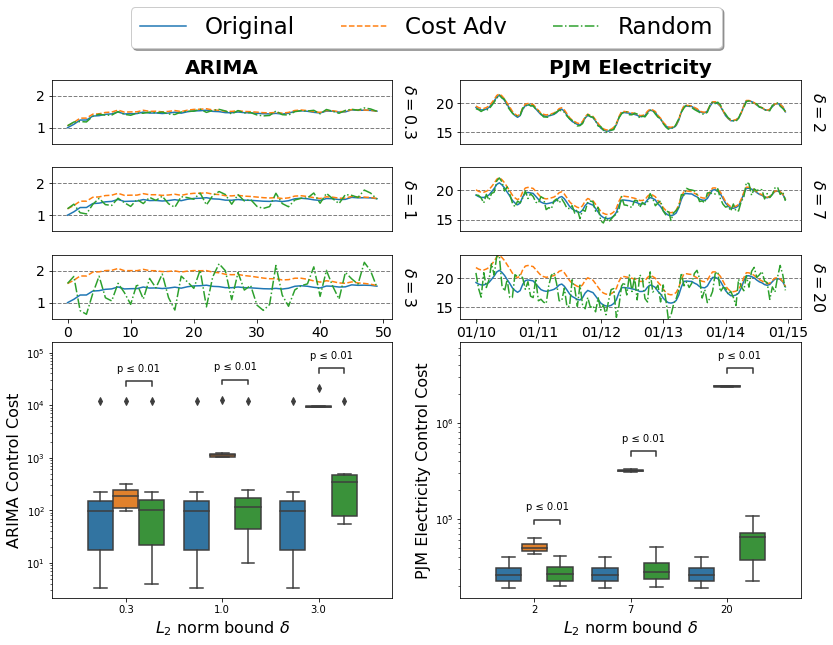

In [132]:
### Cost adv
from statannotations.Annotator import Annotator

ele = pd.read_csv("./csv/AEP_hourly.csv", parse_dates=['Datetime'])
mask = (ele['Datetime'] >= '2015-01-10  00:00:00') & (ele['Datetime'] <= '2015-01-14  23:00:00')
ele = ele.loc[mask]
ele.sort_values(by='Datetime', ascending=True, inplace=True)


### Time series
fig, ts_ax_list = plt.subplots(4, 2, figsize=(13, 9), gridspec_kw={'height_ratios': [1, 1, 1, 4]}) # , sharex='col'
arima_ts = np.load("./plots/ARIMA adv cost ts.npy") ### delta x scebnario x T
pjm_ts = np.load("./plots/PJM adv cost ts.npy") ### delta x scebnario x T

arima_df = pd.read_csv("./plots/ARIMA adv cost.csv", index_col=0)
pjm_df = pd.read_csv("./plots/PJM adv cost.csv", index_col=0)

# print(arima_ts.shape, pjm_ts.shape)
print(arima_df.head(), '\n', pjm_df.head())

flag = 0
sharex_list1 = []
sharex_list2 = []

for (delta1, delta2) in zip(delta_list, delta_list2):

    ts_ax_list[flag, 0].plot(np.arange(arima_ts.shape[2]), arima_ts[flag, 0,:], color=color_list[0], linestyle='-')
    ts_ax_list[flag, 0].plot(np.arange(arima_ts.shape[2]), arima_ts[flag, 1,:], color=color_list[1], linestyle='--')
    ts_ax_list[flag, 0].plot(np.arange(arima_ts.shape[2]), arima_ts[flag, 2,:], color=color_list[2], linestyle='-.')    
    ts_ax_list[flag, 0].set_ylim((0.5, 2.5))
    # ts_ax_list[flag, 0].set_ylabel("$\delta={}$".format(delta1), fontsize=16)
    ts_ax_list[flag, 0].yaxis.grid(True, color ="grey", linestyle='--', linewidth=1)
    ts_ax_list[flag, 0].tick_params(axis='both', which='major', labelsize=14)
    ts_ax_list[flag, 0].text(x=1.05, y=0.5, s="$\delta={}$".format(delta1), size=16, \
        verticalalignment='center', horizontalalignment='center', rotation=270, transform=ts_ax_list[flag, 0].transAxes)


    ts_ax_list[flag, 1].plot(ele['Datetime'], pjm_ts[flag, 0, :], color=color_list[0], linestyle='-')
    ts_ax_list[flag, 1].plot(ele['Datetime'], pjm_ts[flag, 1, :], color=color_list[1], linestyle='--')
    ts_ax_list[flag, 1].plot(ele['Datetime'], pjm_ts[flag, 2, :], color=color_list[2], linestyle='-.')    
    ts_ax_list[flag, 1].set_ylim((13, 24))
    # ts_ax_list[flag, 1].set_ylabel("$\delta={}$".format(delta2), fontsize=16)
    ts_ax_list[flag, 1].yaxis.grid(True, color ="grey", linestyle='--', linewidth=1)
    ts_ax_list[flag, 1].tick_params(axis='both', which='major', labelsize=14)
    ts_ax_list[flag, 1].text(x=1.05, y=0.5, s="$\delta={}$".format(delta2), size=16, \
        verticalalignment='center', horizontalalignment='center', rotation=270, transform=ts_ax_list[flag, 1].transAxes)

    if flag < arima_ts.shape[0]-1 :
        ts_ax_list[flag, 0].axes.get_xaxis().set_visible(False) 
        ts_ax_list[flag, 1].axes.get_xaxis().set_visible(False)

    flag += 1


for ax, col in zip(ts_ax_list[0, :], ("ARIMA", "PJM Electricity")):
    ax.set_title(col, fontsize=20, fontweight="bold")

lgd = fig.legend(["Original", "Cost Adv", "Random"], loc='upper center', bbox_to_anchor=(0.5, 1.03), fancybox=True, shadow=True, ncol=3, fontsize=23)
xlabel1 = ts_ax_list[flag-1, 0].set_xlabel("ARIMA Time Series $S$", fontsize=16)


myFmt = mdates.DateFormatter('%m/%d')
ts_ax_list[flag-1, 1].xaxis.set_major_formatter(myFmt)
xlabel2 = ts_ax_list[flag-1, 1].set_xlabel("PJM Electricity Time Series $S$", fontsize=16)


ax = sns.boxplot(ax=ts_ax_list[flag, 0], data=arima_df, x='$L_2$ norm bound $\delta$', y='Cost', hue='Scenario'
    , palette=[color_list[0], color_list[1], color_list[2]])
ax.legend().remove()
ax.set_yscale('log')
# plt.legend(fontsize=16)
ax.set_xlabel('$L_2$ norm bound $\delta$', fontsize=16)
ax.set_ylabel('ARIMA Control Cost', fontsize=16)

hue_order = ['Original', 'Cost Adv', 'Random']
pairs = []
# pairs = pairs + [((delta, 'Original'), (delta, 'Cost Adv')) for delta in delta_list]
pairs = pairs + [((delta, 'Cost Adv'), (delta, 'Random')) for delta in delta_list]

annotator = Annotator(ax, pairs, data=arima_df, x='$L_2$ norm bound $\delta$', y='Cost', hue='Scenario')#, hue_order=hue_order)
annotator.new_plot(ax, pairs, plot='barplot', data=arima_df, x='$L_2$ norm bound $\delta$', y='Cost', hue='Scenario', hue_order=hue_order, seed=2021)
annotator.configure(test='Wilcoxon', text_format='simple', text_offset=8, show_test_name=False)#, loc='outside')
annotator.apply_and_annotate()


ax = sns.boxplot(ax=ts_ax_list[flag, 1], data=pjm_df, x='$L_2$ norm bound $\delta$', y='Cost', hue='Scenario'
    , palette=[color_list[0], color_list[1], color_list[2]])
ax.legend().remove()
ax.set_yscale('log')
# plt.legend(fontsize=16)
ax.set_xlabel('$L_2$ norm bound $\delta$', fontsize=16)
ax.set_ylabel('PJM Electricity Control Cost', fontsize=16)

hue_order = ['Original', 'Cost Adv', 'Random']
pairs = []
# pairs = pairs + [((delta, 'Original'), (delta, 'Cost Adv')) for delta in delta_list2]
pairs = pairs + [((delta, 'Cost Adv'), (delta, 'Random')) for delta in delta_list2]

annotator = Annotator(ax, pairs, data=pjm_df, x='$L_2$ norm bound $\delta$', y='Cost', hue='Scenario')#, hue_order=hue_order)
annotator.new_plot(ax, pairs, plot='barplot', data=pjm_df, x='$L_2$ norm bound $\delta$', y='Cost', hue='Scenario', hue_order=hue_order, seed=2021)
annotator.configure(test='Wilcoxon', text_format='simple', text_offset=8, show_test_name=False)#, loc='outside')
annotator.apply_and_annotate()

fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.21)
fig.savefig("./plots/ARIMA_PJM_adv_cost_time_series.pdf", dpi=1000, bbox_inches="tight") #, bbox_extra_artists=(lgd,xlabel1, xlabel2)

### Constraint Adv

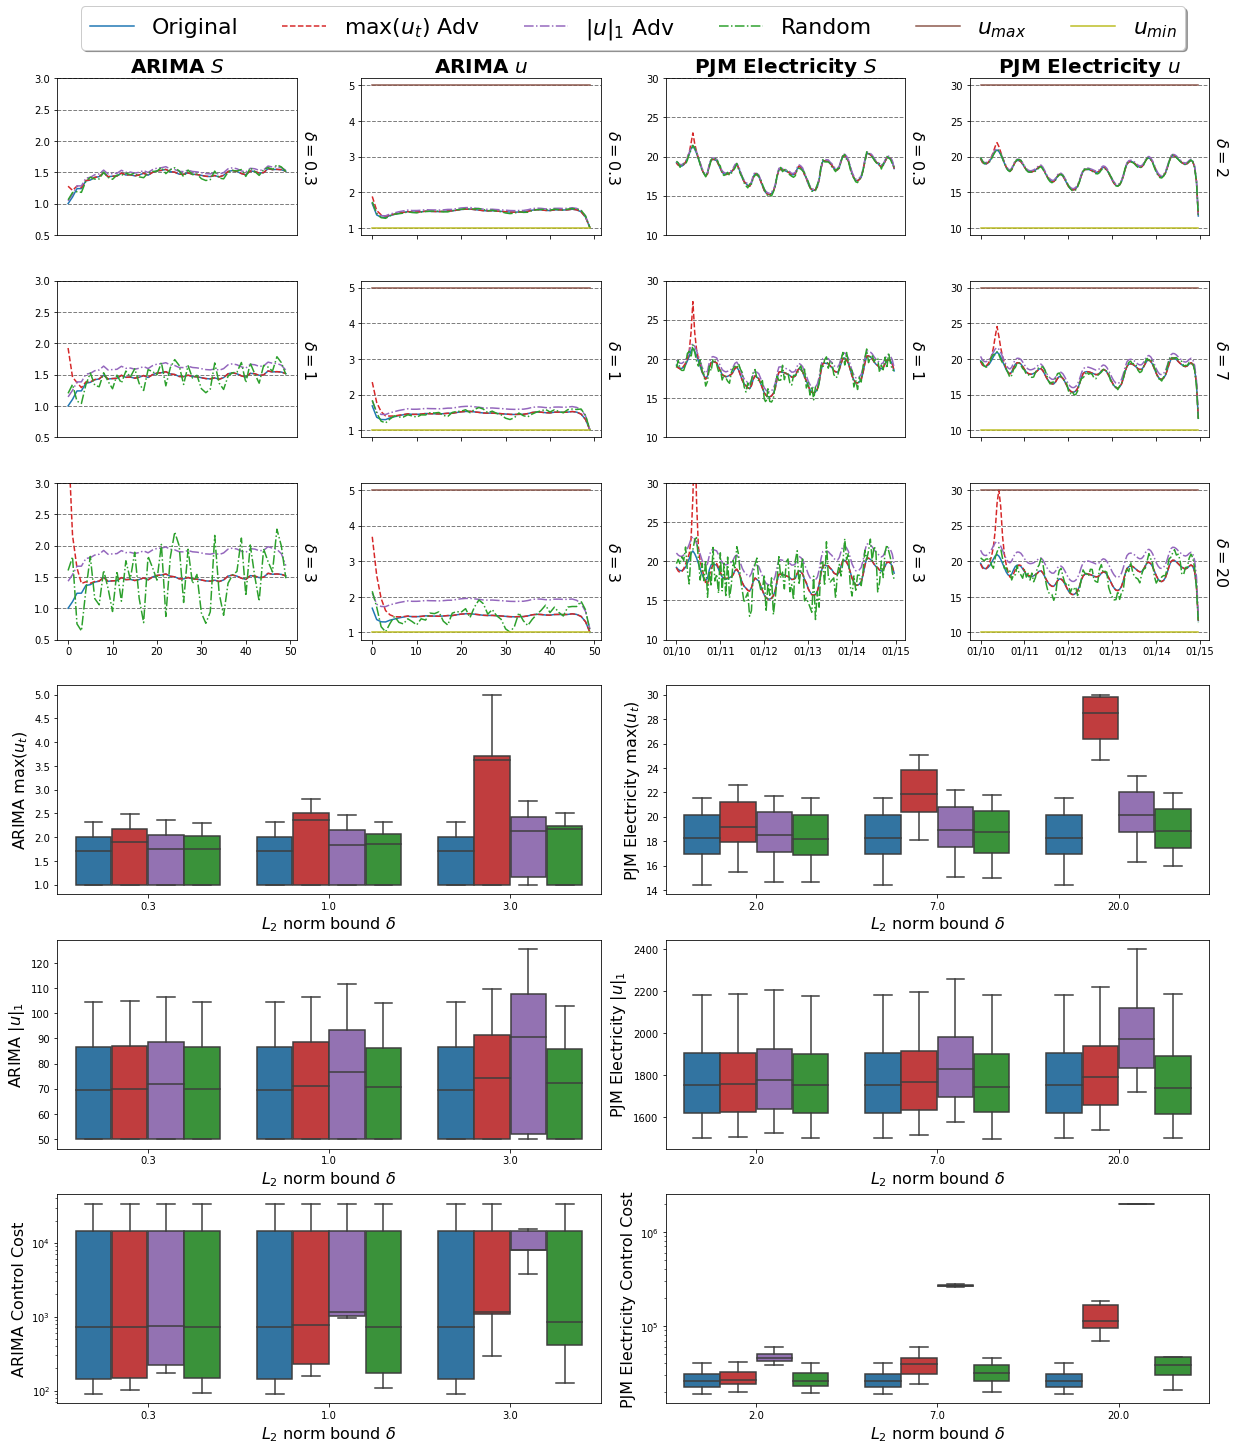

In [154]:
### Constr adv
from statannotations.Annotator import Annotator

ele = pd.read_csv("./csv/AEP_hourly.csv", parse_dates=['Datetime'])
mask = (ele['Datetime'] >= '2015-01-10  00:00:00') & (ele['Datetime'] <= '2015-01-14  23:00:00')
ele = ele.loc[mask]
ele.sort_values(by='Datetime', ascending=True, inplace=True)


### Time series
fig, ax_list = plt.subplot_mosaic(\
        [["ARIMAts0", "ARIMAu0", "PJMts0", "PJMu0"], \
        ["ARIMAts1", "ARIMAu1", "PJMts1", "PJMu1"], \
        ["ARIMAts2", "ARIMAu2", "PJMts2", "PJMu2"], \
        ["ARIMAumax", "ARIMAumax", "PJMumax", "PJMumax"], \
        ["ARIMAuabs", "ARIMAuabs", "PJMuabs", "PJMuabs"], \
        ["ARIMAcost", "ARIMAcost", "PJMcost", "PJMcost"]], \
        figsize=(20, 23), 
        gridspec_kw={
            # set the height ratios between the rows
            "height_ratios": [1.5, 1.5, 1.5, 2, 2, 2],
            # set the width ratios between the columns
            "width_ratios": [1, 1, 1, 1],})

arima_ts = np.load("./plots/ARIMA adv constr ts.npy") ### delta x scebnario x T
pjm_ts = np.load("./plots/PJM adv constr ts.npy") ### delta x scebnario x T

arima_u = np.load("./plots/ARIMA adv constr u.npy") ### delta x scebnario x T
pjm_u = np.load("./plots/PJM adv constr u.npy") ### delta x scebnario x T

arima_df = pd.read_csv("./plots/ARIMA adv constr.csv", index_col=0)
pjm_df = pd.read_csv("./plots/PJM adv constr.csv", index_col=0)

arima_umax_df = pd.read_csv("./plots/ARIMA umax.csv", index_col=0)
arima_uabs_df = pd.read_csv("./plots/ARIMA uabs.csv", index_col=0)
pjm_uabs_df = pd.read_csv("./plots/pjm umax.csv", index_col=0)
pjm_uabs_df = pd.read_csv("./plots/pjm uabs.csv", index_col=0)


# print(arima_ts.shape, pjm_ts.shape, pjm_ts[0])
# print(arima_u.shape, pjm_u.shape, pjm_u[0])
# print(arima_df.head(), '\n', pjm_df.head())
# print(arima_ts)
        

flag = 0
sharex_list1 = []
sharex_list2 = []

for (delta1, delta2) in zip(delta_list, delta_list2):

    ax_list["ARIMAts"+str(flag)].plot(np.arange(arima_ts.shape[2]), arima_ts[flag, 0, :], color=color_list[0], linestyle='-')
    ax_list["ARIMAts"+str(flag)].plot(np.arange(arima_ts.shape[2]), arima_ts[flag, 1, :], color=color_list[3], linestyle='--')
    ax_list["ARIMAts"+str(flag)].plot(np.arange(arima_ts.shape[2]), arima_ts[flag, 2, :], color=color_list[4], linestyle='-.')    
    ax_list["ARIMAts"+str(flag)].plot(np.arange(arima_ts.shape[2]), arima_ts[flag, 3, :], color=color_list[2], linestyle='-.')    
    ax_list["ARIMAts"+str(flag)].set_ylim(0.5, 3)
    # ax_list["ARIMAts"+str(flag)].set_ylabel("$\delta={}$".format(delta1), fontsize=16)
    ax_list["ARIMAts"+str(flag)].text(x=1.05, y=0.5, s="$\delta={}$".format(delta1), size=16, \
        verticalalignment='center', horizontalalignment='center', rotation=270, transform=ax_list["ARIMAts"+str(flag)].transAxes)
    ax_list["ARIMAts"+str(flag)].yaxis.grid(True, color ="grey", linestyle='--', linewidth=1)

    ax_list["ARIMAu"+str(flag)].plot(np.arange(arima_u.shape[2]), arima_u[flag, 0, :], color=color_list[0], linestyle='-', label="Original")
    ax_list["ARIMAu"+str(flag)].plot(np.arange(arima_u.shape[2]), arima_u[flag, 1, :], color=color_list[3], linestyle='--', label="max($u_t$) Adv")
    ax_list["ARIMAu"+str(flag)].plot(np.arange(arima_u.shape[2]), arima_u[flag, 2, :], color=color_list[4], linestyle='-.', label="$\|u\|_1$ Adv")    
    ax_list["ARIMAu"+str(flag)].plot(np.arange(arima_u.shape[2]), arima_u[flag, 3, :], color=color_list[2], linestyle='-.', label="Random")    
    ax_list["ARIMAu"+str(flag)].plot(np.arange(arima_u.shape[2]), arima_u[flag, 4, :], color=color_list[5], linestyle='-', label="$u_{max}$")    
    ax_list["ARIMAu"+str(flag)].plot(np.arange(arima_u.shape[2]), arima_u[flag, 5, :], color=color_list[8], linestyle='-', label="$u_{min}$")    
    # ax_list["ARIMAu"+str(flag)].set_xlabel("$\|u\|_1={:.1f}$".format(np.linalg.norm(arima_u[flag, 2, :], ord=1)), fontsize=16)
    ax_list["ARIMAu"+str(flag)].text(x=1.05, y=0.5, s="$\delta={}$".format(delta1), size=16, \
        verticalalignment='center', horizontalalignment='center', rotation=270, transform=ax_list["ARIMAu"+str(flag)].transAxes)
    ax_list["ARIMAu"+str(flag)].yaxis.grid(True, color ="grey", linestyle='--', linewidth=1)


    ax_list["PJMts"+str(flag)].plot(ele['Datetime'], pjm_ts[flag, 0, :], color=color_list[0], linestyle='-')
    ax_list["PJMts"+str(flag)].plot(ele['Datetime'], pjm_ts[flag, 1, :], color=color_list[3], linestyle='--')
    ax_list["PJMts"+str(flag)].plot(ele['Datetime'], pjm_ts[flag, 2, :], color=color_list[4], linestyle='-.')    
    ax_list["PJMts"+str(flag)].plot(ele['Datetime'], pjm_ts[flag, 3, :], color=color_list[2], linestyle='-.')    
    ax_list["PJMts"+str(flag)].set_ylim((10, 30))
    # ax_list["PJMts"+str(flag)].set_ylabel("$\delta={}$".format(delta2), fontsize=16)
    ax_list["PJMts"+str(flag)].text(x=1.05, y=0.5, s="$\delta={}$".format(delta1), size=16, \
            verticalalignment='center', horizontalalignment='center', rotation=270, transform=ax_list["PJMts"+str(flag)].transAxes)
    ax_list["PJMts"+str(flag)].yaxis.grid(True, color ="grey", linestyle='--', linewidth=1)

    ax_list["PJMu"+str(flag)].plot(ele['Datetime'], pjm_u[flag, 0, :], color=color_list[0], linestyle='-', label="Original")
    ax_list["PJMu"+str(flag)].plot(ele['Datetime'], pjm_u[flag, 1, :], color=color_list[3], linestyle='--', label="max($u_t$) Adv")
    ax_list["PJMu"+str(flag)].plot(ele['Datetime'], pjm_u[flag, 2, :], color=color_list[4], linestyle='-.', label="$\|u\|_1$ Adv")    
    ax_list["PJMu"+str(flag)].plot(ele['Datetime'], pjm_u[flag, 3, :], color=color_list[2], linestyle='-.', label="Random")    
    ax_list["PJMu"+str(flag)].plot(ele['Datetime'], pjm_u[flag, 4, :], color=color_list[5], linestyle='-', label="$u_{max}$")    
    ax_list["PJMu"+str(flag)].plot(ele['Datetime'], pjm_u[flag, 5, :], color=color_list[8], linestyle='-', label="$u_{min}$")    
    # ax_list["PJMu"+str(flag)].set_xlabel("$\|u\|_1={:.1f}$".format(np.linalg.norm(pjm_u[flag, 2, :], ord=1)), fontsize=16)
    ax_list["PJMu"+str(flag)].text(x=1.05, y=0.5, s="$\delta={}$".format(delta2), size=16, \
        verticalalignment='center', horizontalalignment='center', rotation=270, transform=ax_list["PJMu"+str(flag)].transAxes)
    ax_list["PJMu"+str(flag)].yaxis.grid(True, color ="grey", linestyle='--', linewidth=1)

    if flag < arima_ts.shape[0]-1 :
        ax_list["ARIMAts"+str(flag)].axes.get_xaxis().set_visible(False) 
        # ax_list["ARIMAu"+str(flag)].axes.get_xticklabels().set_visible(False)
        plt.setp(ax_list["ARIMAu"+str(flag)].get_xticklabels(), visible=False)
        ax_list["PJMts"+str(flag)].axes.get_xaxis().set_visible(False) 
        # ax_list["PJMu"+str(flag)].axes.get_xticklabels().set_visible(False)
        plt.setp(ax_list["PJMu"+str(flag)].get_xticklabels(), visible=False)
    
    flag += 1


for ax, col in zip(["ARIMAts0", "ARIMAu0", "PJMts0", "PJMu0"], ["ARIMA $S$", "ARIMA $u$", "PJM Electricity $S$", "PJM Electricity $u$"]):
    ax_list[ax].set_title(col, fontsize=20, fontweight="bold")

# lgd = fig.legend(["Original", "max($u_t$) Adv", "$\|u\|_1$ Adv", "Random", "$u_{max}$", "$u_{min}$"], loc='upper center', \
h, l = ax_list["PJMu0"].get_legend_handles_labels()
lgd = fig.legend(h, l, loc='upper center', bbox_to_anchor=(0.5, 0.95), fancybox=True, shadow=True, ncol=6, fontsize=22)
# xlabel1 = ax_list[flag-1, 0].set_xlabel("ARIMA Time Series $S$", fontsize=16)

myFmt = mdates.DateFormatter('%m/%d')
ax_list["PJMts"+str(flag-1)].xaxis.set_major_formatter(myFmt)
ax_list["PJMu"+str(flag-1)].xaxis.set_major_formatter(myFmt)
# xlabel2 = ax_list["PJMu"+str(flag-1)].set_xlabel("PJM Time Series $S$", fontsize=16)

### umax boplot
ax3 = sns.boxplot(ax=ax_list["ARIMAumax"], data=arima_umax_df, x='$L_2$ norm bound $\delta$', y='umax', hue='Target Function' #, title='Control Cost: $J^c(\hat{u};S, x_0)$'
    , palette=[color_list[0], color_list[3], color_list[4], color_list[2]], showfliers=False)
ax3.legend().remove()
ax3.set_xlabel('$L_2$ norm bound $\delta$', fontsize=16)
ax3.set_ylabel('ARIMA max($u_t$)', fontsize=16)

ax4 = sns.boxplot(ax=ax_list["PJMumax"], data=pjm_umax_df, x='$L_2$ norm bound $\delta$', y='umax', hue='Target Function' #, title='Control Cost: $J^c(\hat{u};S, x_0)$'
    , palette=[color_list[0], color_list[3], color_list[4], color_list[2]], showfliers=False)
ax4.legend().remove()
ax4.set_xlabel('$L_2$ norm bound $\delta$', fontsize=16)
ax4.set_ylabel('PJM Electricity max($u_t$)', fontsize=16)

### uabs boplot
ax5 = sns.boxplot(ax=ax_list["ARIMAuabs"], data=arima_uabs_df, x='$L_2$ norm bound $\delta$', y='uabs', hue='Target Function' #, title='Control Cost: $J^c(\hat{u};S, x_0)$'
    , palette=[color_list[0], color_list[3], color_list[4], color_list[2]], showfliers=False)
ax5.legend().remove()
ax5.set_xlabel('$L_2$ norm bound $\delta$', fontsize=16)
ax5.set_ylabel('ARIMA $\|u\|_1$', fontsize=16)

ax6 = sns.boxplot(ax=ax_list["PJMuabs"], data=pjm_uabs_df, x='$L_2$ norm bound $\delta$', y='uabs', hue='Target Function' #, title='Control Cost: $J^c(\hat{u};S, x_0)$'
    , palette=[color_list[0], color_list[3], color_list[4], color_list[2]], showfliers=False)
ax6.legend().remove()
ax6.set_xlabel('$L_2$ norm bound $\delta$', fontsize=16)
ax6.set_ylabel('PJM Electricity $\|u\|_1$', fontsize=16)

### cost boxplot
ax = sns.boxplot(ax=ax_list["ARIMAcost"], data=arima_df, x='$L_2$ norm bound $\delta$', y='Cost', hue='Target Function' #, title='Control Cost: $J^c(\hat{u};S, x_0)$'
    , palette=[color_list[0], color_list[3], color_list[4], color_list[2]], showfliers=False)
ax.legend().remove()
ax.set_xlabel('$L_2$ norm bound $\delta$', fontsize=16)
ax.set_ylabel('ARIMA Control Cost', fontsize=16)
ax.set_yscale('log')

ax2 = sns.boxplot(ax=ax_list["PJMcost"], data=pjm_df, x='$L_2$ norm bound $\delta$', y='Cost', hue='Target Function' #, title='Control Cost: $J^c(\hat{u};S, x_0)$'
    , palette=[color_list[0], color_list[3], color_list[4], color_list[2]], showfliers=False)
ax2.legend().remove()
ax2.set_xlabel('$L_2$ norm bound $\delta$', fontsize=16)
ax2.set_ylabel('PJM Electricity Control Cost', fontsize=16)
ax2.set_yscale('log')

fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.27, hspace=0.25)
fig.savefig("./plots/ARIMA_PJM_adv_constr.pdf", dpi=1000, bbox_inches="tight") # bbox_extra_artists=(lgd,xlabel1, xlabel2, ),


### Calculate Statistics

In [162]:
arima_df = pd.read_csv("./plots/ARIMA adv cost.csv", index_col=0)
pjm_df = pd.read_csv("./plots/PJM adv cost.csv", index_col=0)

arima_orig_cost = arima_df.loc[(arima_df["$L_2$ norm bound $\delta$"] == 0.3) & (arima_df["Scenario"] == "Original")]["Cost"].mean()

print(arima_orig_cost)
print(arima_df.loc[(arima_df["$L_2$ norm bound $\delta$"] == 0.3) & (arima_df["Scenario"] == "Cost Adv")]["Cost"].mean()/arima_orig_cost)
print(arima_df.loc[(arima_df["$L_2$ norm bound $\delta$"] == 1) & (arima_df["Scenario"] == "Cost Adv")]["Cost"].mean()/arima_orig_cost)
print(arima_df.loc[(arima_df["$L_2$ norm bound $\delta$"] == 3) & (arima_df["Scenario"] == "Cost Adv")]["Cost"].mean()/arima_orig_cost)


pjm_orig_cost = pjm_df.loc[(pjm_df["$L_2$ norm bound $\delta$"] == 2) & (pjm_df["Scenario"] == "Original")]["Cost"].mean()

print(pjm_orig_cost)
print(pjm_df.loc[(pjm_df["$L_2$ norm bound $\delta$"] == 2) & (pjm_df["Scenario"] == "Cost Adv")]["Cost"].mean()/pjm_orig_cost)
print(pjm_df.loc[(pjm_df["$L_2$ norm bound $\delta$"] == 7) & (pjm_df["Scenario"] == "Cost Adv")]["Cost"].mean()/pjm_orig_cost)
print(pjm_df.loc[(pjm_df["$L_2$ norm bound $\delta$"] == 20) & (pjm_df["Scenario"] == "Cost Adv")]["Cost"].mean()/pjm_orig_cost)

1251.3007228486308
1.0742743539910058
1.8252705999000638
8.427435399100576
27774.088981015702
1.8473968921307753
11.380611928601988
85.73968921307747


In [171]:
arima_df = pd.read_csv("./plots/ARIMA umax.csv", index_col=0)
pjm_df = pd.read_csv("./plots/pjm umax.csv", index_col=0)

arima_umax = arima_df.loc[(arima_df["$L_2$ norm bound $\delta$"] == 0.3) & (arima_df["Target Function"] == "Original")]["umax"].mean()

print(arima_umax)
print(arima_df.loc[(arima_df["$L_2$ norm bound $\delta$"] == 0.3) & (arima_df["Target Function"] == "max($u_t$) Adv")]["umax"].mean()/arima_umax)
print(arima_df.loc[(arima_df["$L_2$ norm bound $\delta$"] == 1) & (arima_df["Target Function"] == "max($u_t$) Adv")]["umax"].mean()/arima_umax)
print(arima_df.loc[(arima_df["$L_2$ norm bound $\delta$"] == 3) & (arima_df["Target Function"] == "max($u_t$) Adv")]["umax"].mean()/arima_umax)

pjm_umax = pjm_df.loc[(pjm_df["$L_2$ norm bound $\delta$"] == 2.0) & (pjm_df["Target Function"] == "Original")]["umax"].mean()

print(pjm_umax)
print(pjm_df.loc[(pjm_df["$L_2$ norm bound $\delta$"] == 2.0) & (pjm_df["Target Function"] == "max($u_t$) Adv")]["umax"].mean()/pjm_umax)
print(pjm_df.loc[(pjm_df["$L_2$ norm bound $\delta$"] == 7.0) & (pjm_df["Target Function"] == "max($u_t$) Adv")]["umax"].mean()/pjm_umax)
print(pjm_df.loc[(pjm_df["$L_2$ norm bound $\delta$"] == 20.0) & (pjm_df["Target Function"] == "max($u_t$) Adv")]["umax"].mean()/pjm_umax)

1.8684861805276936
1.0463592398470518
1.1479436659624007
1.4664245148978212
18.234356163632718
1.0552485235285902
1.195851808367938
1.5325595442260747


In [174]:
arima_df = pd.read_csv("./plots/ARIMA uabs.csv", index_col=0)
pjm_df = pd.read_csv("./plots/pjm uabs.csv", index_col=0)

arima_uabs = arima_df.loc[(arima_df["$L_2$ norm bound $\delta$"] == 0.3) & (arima_df["Target Function"] == "Original")]["uabs"].mean()

print(arima_uabs)
print(arima_df.loc[(arima_df["$L_2$ norm bound $\delta$"] == 0.3) & (arima_df["Target Function"] == "$\|u\|_1$ Adv")]["uabs"].mean()/arima_uabs)
print(arima_df.loc[(arima_df["$L_2$ norm bound $\delta$"] == 1) & (arima_df["Target Function"] == "$\|u\|_1$ Adv")]["uabs"].mean()/arima_uabs)
print(arima_df.loc[(arima_df["$L_2$ norm bound $\delta$"] == 3) & (arima_df["Target Function"] == "$\|u\|_1$ Adv")]["uabs"].mean()/arima_uabs)

pjm_uabs = pjm_df.loc[(pjm_df["$L_2$ norm bound $\delta$"] == 2.0) & (pjm_df["Target Function"] == "Original")]["uabs"].mean()

print(pjm_uabs)
print(pjm_df.loc[(pjm_df["$L_2$ norm bound $\delta$"] == 2.0) & (pjm_df["Target Function"] == "$\|u\|_1$ Adv")]["uabs"].mean()/pjm_uabs)
print(pjm_df.loc[(pjm_df["$L_2$ norm bound $\delta$"] == 7.0) & (pjm_df["Target Function"] == "$\|u\|_1$ Adv")]["uabs"].mean()/pjm_uabs)
print(pjm_df.loc[(pjm_df["$L_2$ norm bound $\delta$"] == 20.0) & (pjm_df["Target Function"] == "$\|u\|_1$ Adv")]["uabs"].mean()/pjm_uabs)

86.34421533759901
1.01212825419774
1.040427515287074
1.1299677241255144
1793.8227847861704
1.0121442011668293
1.0425051722332248
1.1214564289800604
